In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():    
    os.chdir("..")
    global changed
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

In [2]:
config_path = "configs/configs_cats_BPH"
temp_results_path = 'temp_results/cats_BPH.csv'
results_path = 'results_csvs/cats_BPH.csv'
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Cats


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


In [7]:
print(np.max(lnprobs0))

-72908.85001905146


thresh: -73850.68757492695


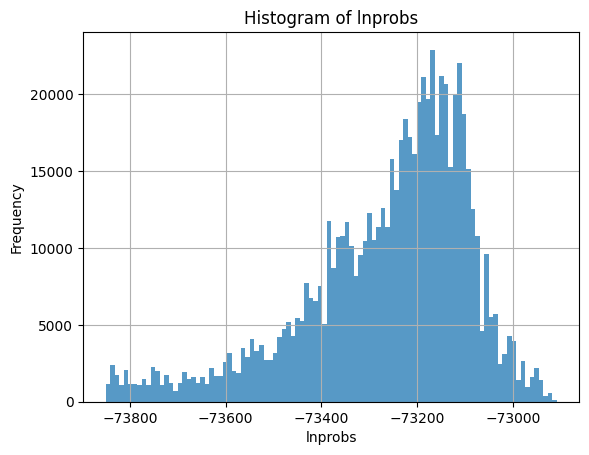

In [8]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 86)
print(f"thresh: {thresh}")

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [9]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [10]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]

In [11]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [12]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



In [ ]:
if False:
    from SRtools import samples_utils as ssu
    from SRtools import config_lib as ccl
    config_dict = ccl.config_to_dict(config)
    path1 = 'cats_BPH.csv'
    post_path = os.path.join('posterior_csvs',path1.replace('.csv','_post.csv'))

    help_text ="run from baysian01"

    post = ssu.Posterior(samples_trans, lnprobs, 100, log=True,config_params=config_dict,help_text=help_text)
    post.save_to_file(post_path)

Averaging log-probabilities: 100%|██████████| 7786/7786 [00:00<00:00, 401900.79it/s]


(25,)


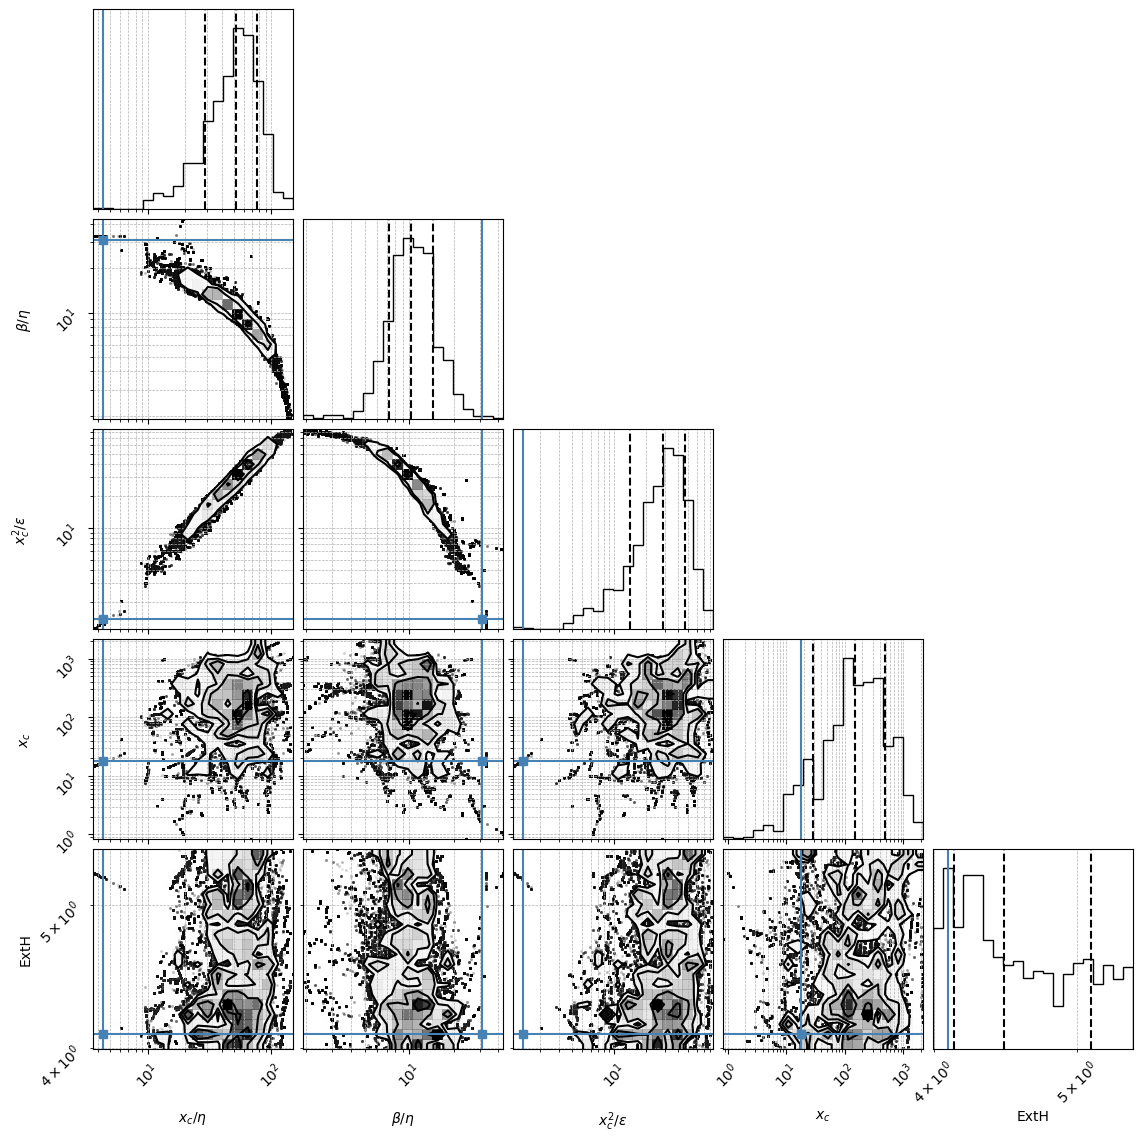

In [69]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=sorted_samples_trans[-1])
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

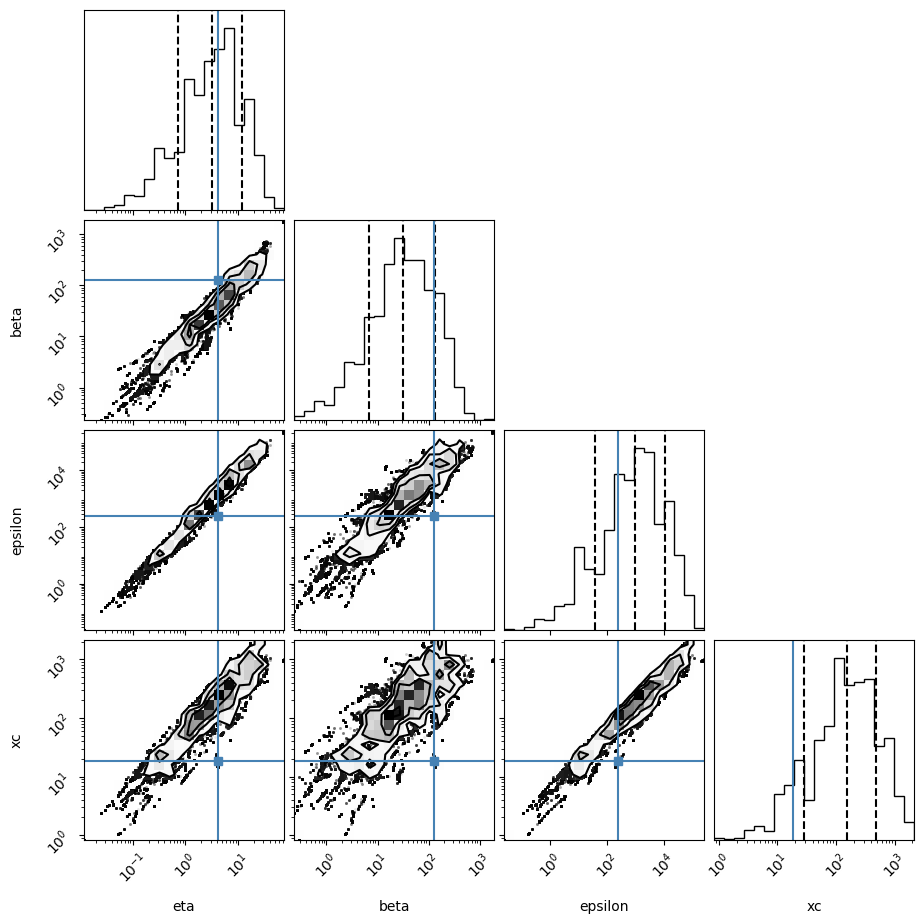

In [70]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc','ExtH'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=sorted_samples[-1])

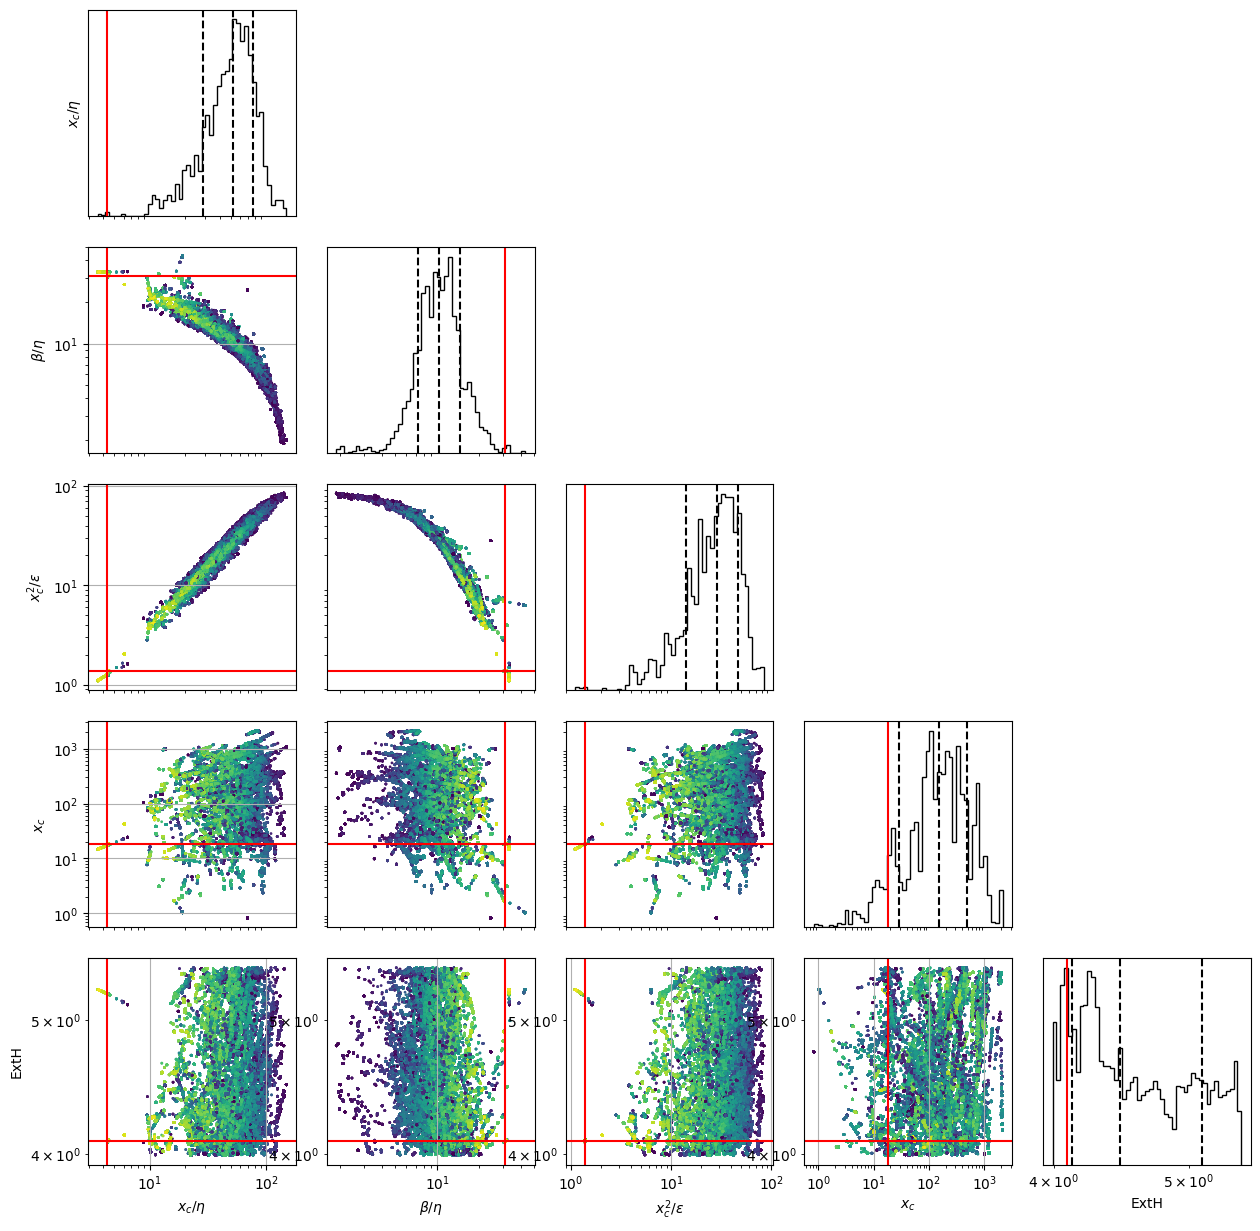

In [71]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= sorted_samples_trans[-1], labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"])

In [72]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                            Eta    Beta   Epsilon      Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps  Fk/Dk  Fk^2/Dk  t_eta  Median Lifetime
Best fit                   4.19  129.68    241.77   18.27     30.92         9.80              219.50                   22.40      1.38           0.270                8020.22                   29905.09                    0.66             0.320   0.076  0.270  2150.94   2.09            14.00
Median                     3.26   31.71   1009.86  153.02     10.26         5.69                2.04                    0.36     28.58           0.018                 600.32                   38219.28                    3.97             0.550   0.170  0.018    11.85   7.18            14.00
Mean                       5.91   71.10   6648.31  271.67     11.06         5.70                5.77                    0.78   

In [73]:
best_theta = sorted_samples[-1]

best_sim = srmc.getSr(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=sorted_samples_trans[-1][4], parallel =True)


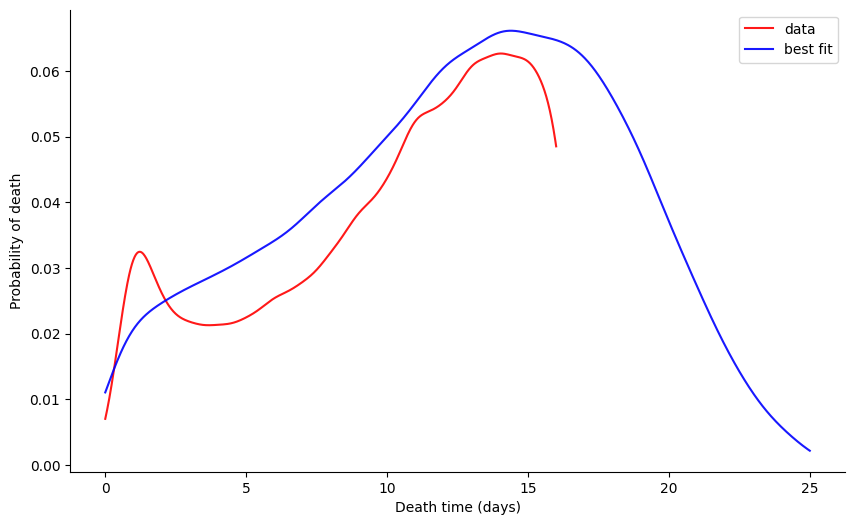

In [74]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=True, label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=True, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 7786/7786 [00:00<00:00, 389240.05it/s]


low: 0.11686216785851228, high: 1.4636706808755142
low: 1.2954408646976319, high: 1.2954408646976319
low: 2.9659177888326473, high: 3.0285413216626296
low: 0.11686216785851228, high: 1.4636706808755142
low: 2.7576428673363504, high: 2.7576428673363504
low: 1.4037528521146676, high: 1.4068947543356793


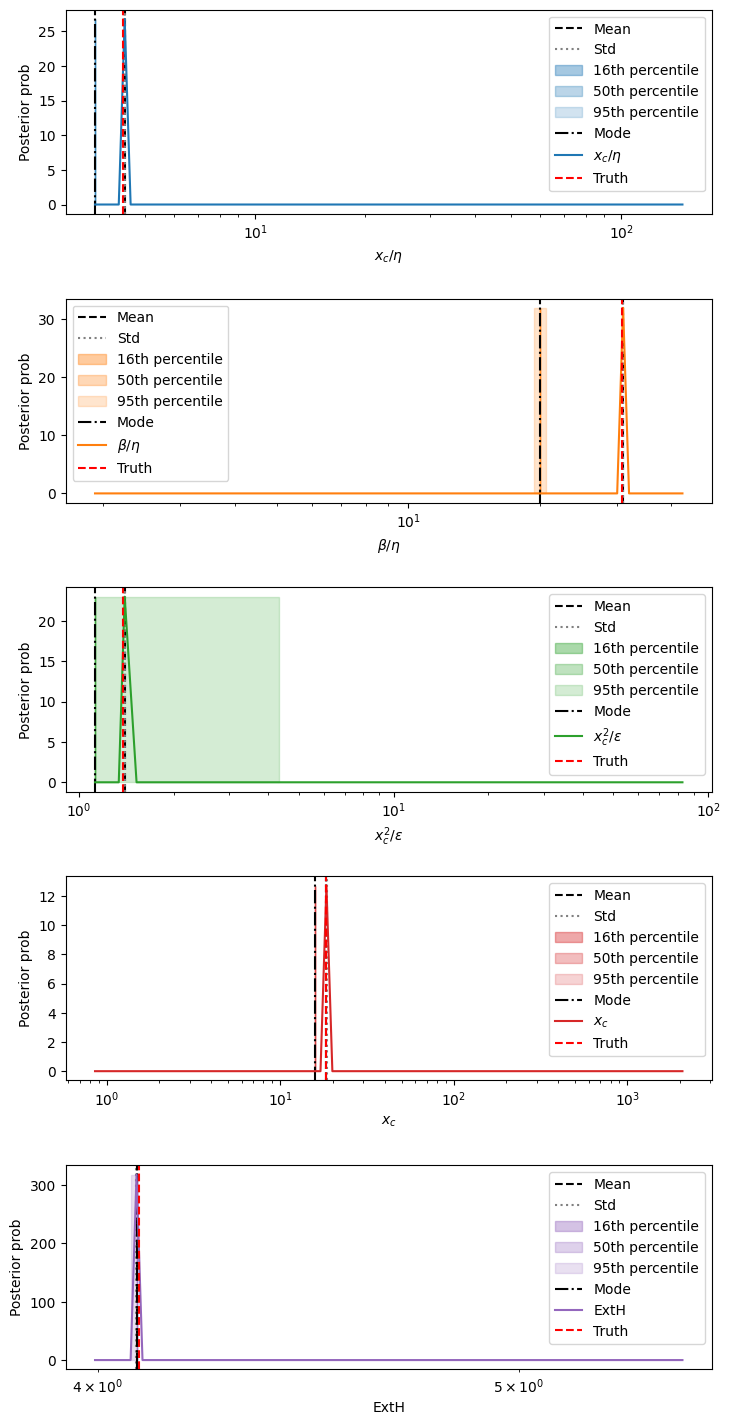

In [116]:
import samples_utils as su
post = su.Posterior(samples_trans, lnprobs, 100, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=sorted_samples_trans[-1],scale='log')

Creating corner plot:   0%|          | 0/5 [00:00<?, ?it/s]/Volumes/alon/navehr/baysian01/samples_utils.py:626: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>, <Axes: >],
       [<Axes: title={'center': '2D Posterio

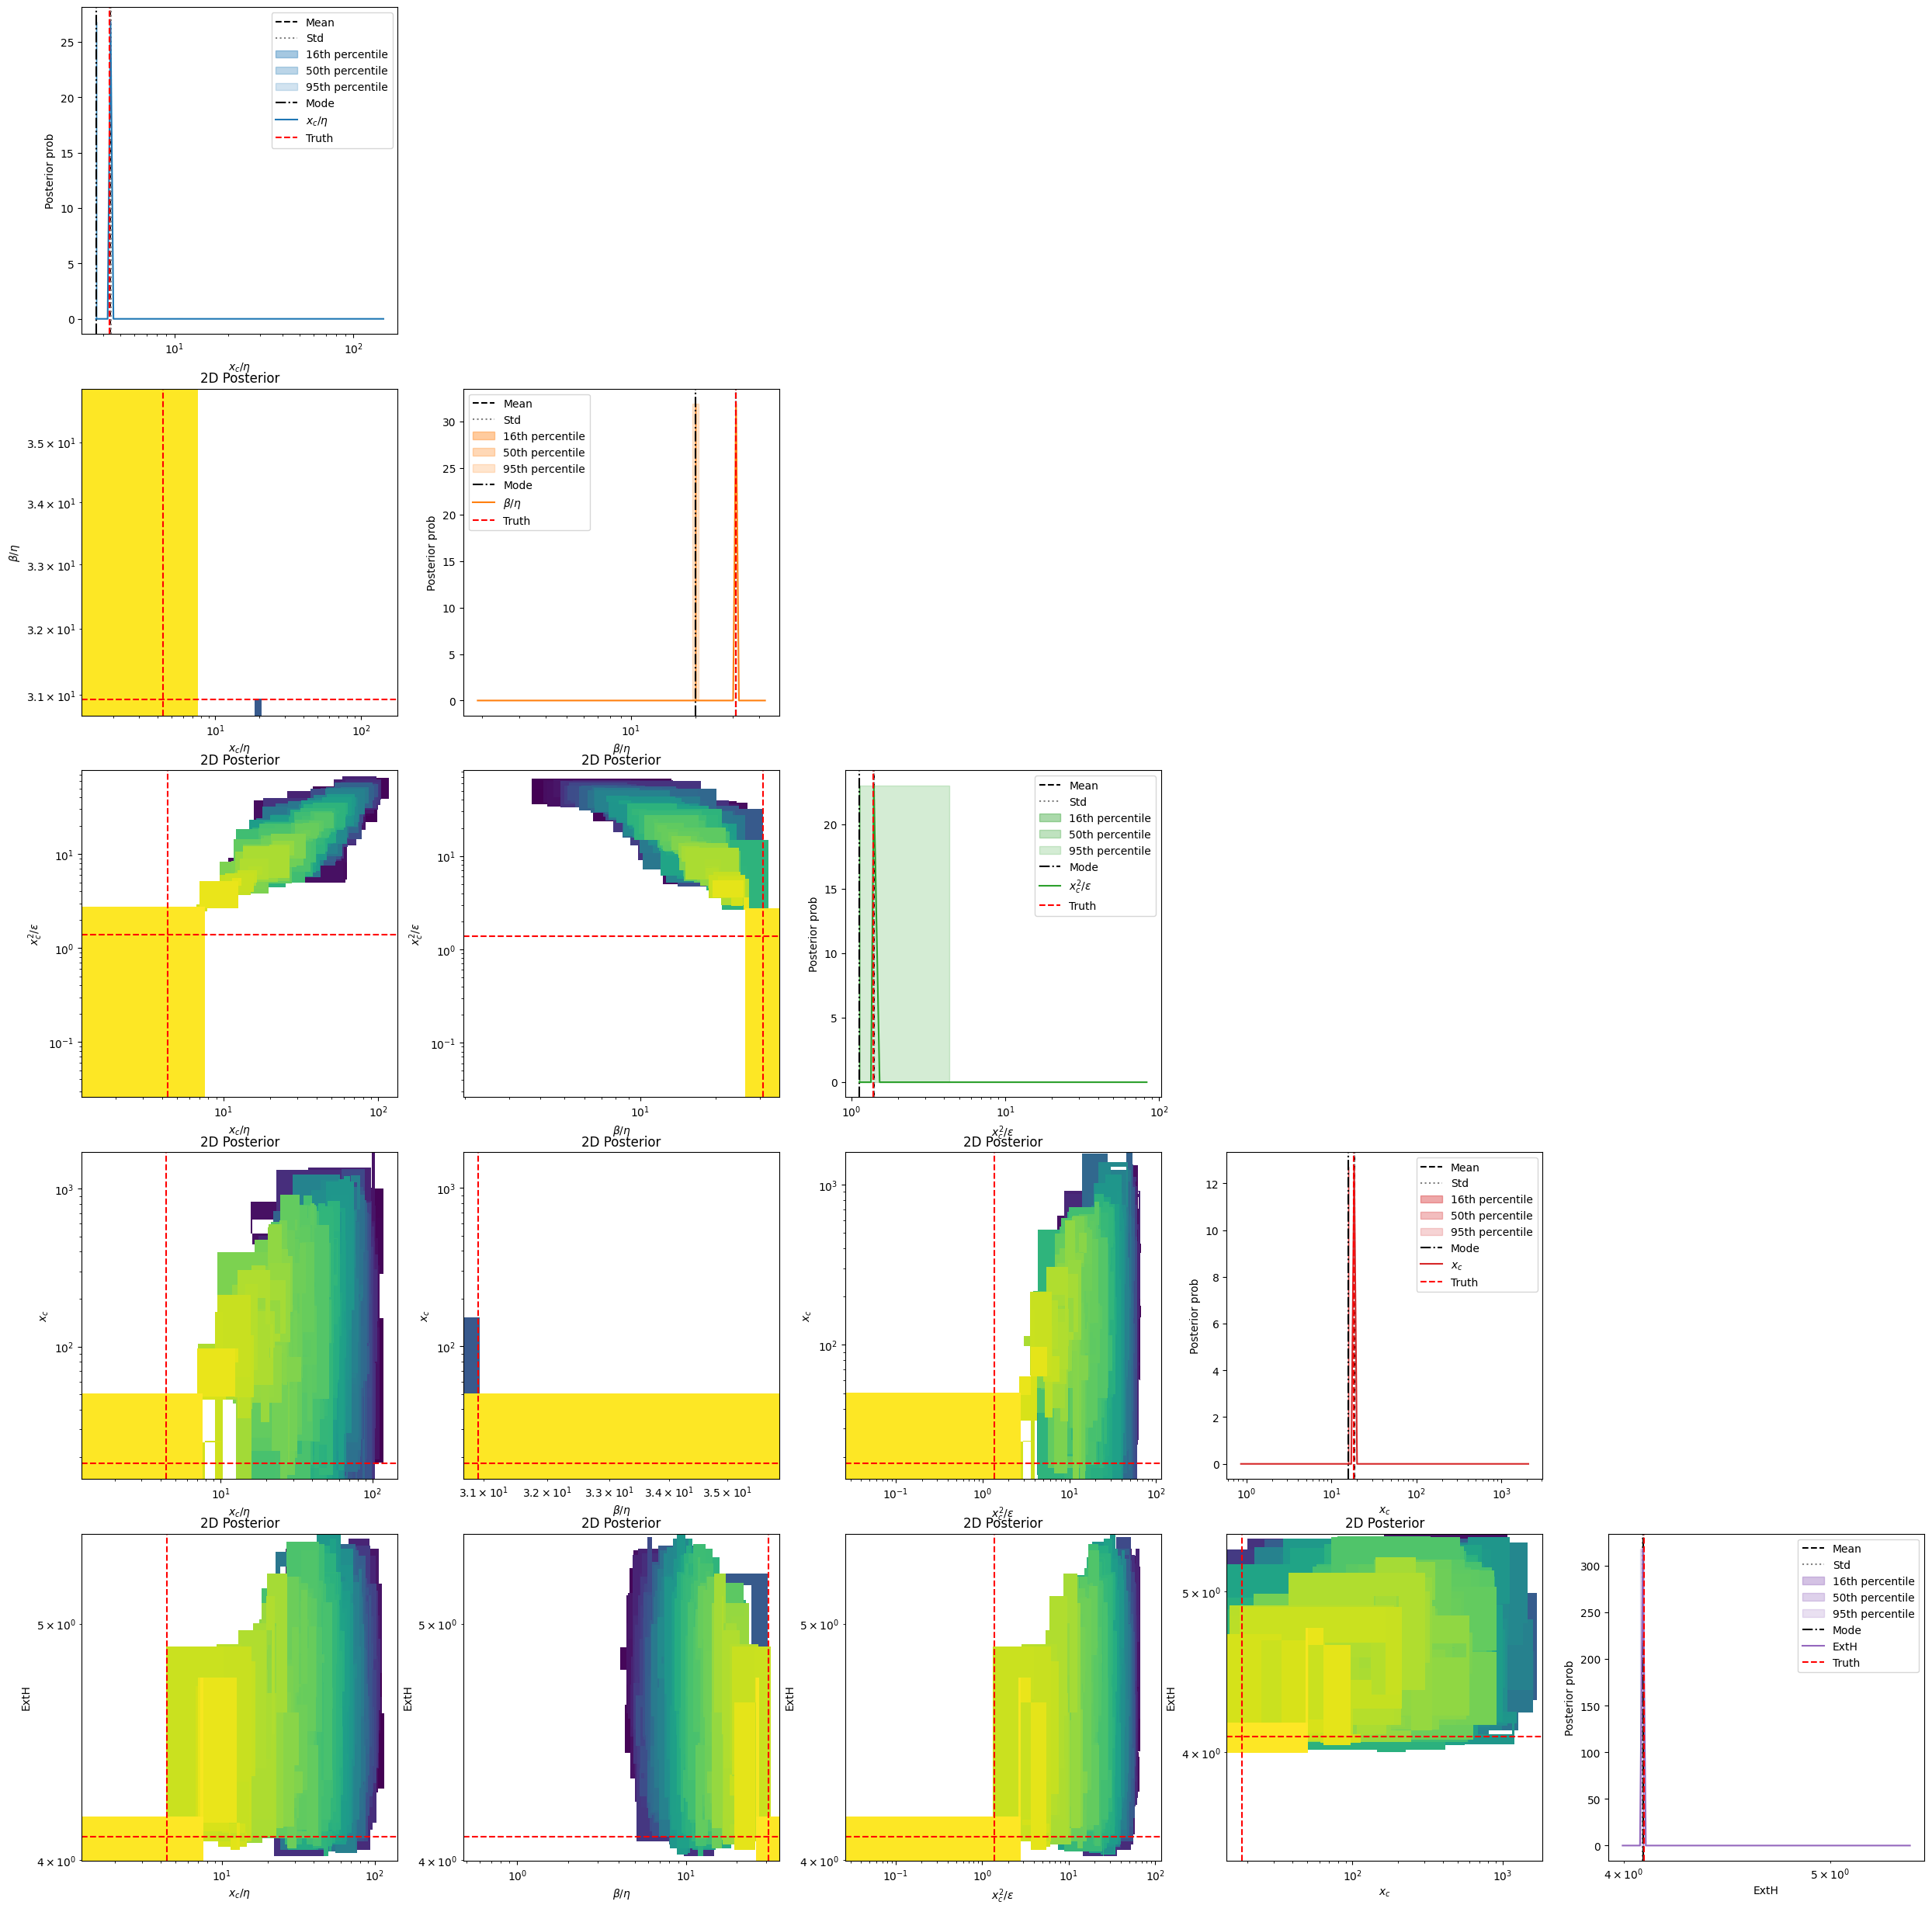

In [76]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log',plot_type='pcolormesh')

In [117]:
path_days = f"{results_path.split('.csv')[0]}_days.csv"
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])
df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=365)


Averaging log-probabilities: 100%|██████████| 7786/7786 [00:00<00:00, 395045.74it/s]


low: 1.2954408646976319, high: 1.2954408646976319
low: 2.9659177888326473, high: 3.0285413216626296
low: 0.11686216785851228, high: 1.4636706808755142
low: 2.7576428673363504, high: 2.7576428673363504
low: 1.4037528521146676, high: 1.4068947543356793


Averaging log-probabilities: 100%|██████████| 7257/7257 [00:00<00:00, 400495.57it/s]


low: 1.470101439277296, high: 2.2576092106807124
low: 4.897415138882149, high: 4.987685904580011
low: 7.388340728247937, high: 7.550682370293913


Averaging log-probabilities: 100%|██████████| 8050/8050 [00:00<00:00, 361245.24it/s]


low: 0.6477204323488159, high: 0.6477204323488159
low: 0.20756178701787042, high: 0.2330498806271583
low: 2.084438872682488, high: 2.1106148185770763


Averaging log-probabilities: 100%|██████████| 8296/8296 [00:00<00:00, 397831.63it/s]


low: -0.9513631072383381, high: -0.9400702950478081
low: 3.6941670307789027, high: 3.7882026124750956
low: 1.564383559013562, high: 1.636458830937722


Averaging log-probabilities: 100%|██████████| 7585/7585 [00:00<00:00, 404097.60it/s]


low: -3.193292827191464, high: -3.0019626764221137
low: 8.914115420665766, high: 9.025415401492207


Averaging log-probabilities: 100%|██████████| 7604/7604 [00:00<00:00, 359849.80it/s]


low: 11.843609712545021, high: 11.843609712545021
low: 5.648483292460639, high: 5.7646334285071665
Rescaling the samples TIME by 365


Averaging log-probabilities: 100%|██████████| 7806/7806 [00:00<00:00, 339877.47it/s]


low: 13.083553775102523, high: 16.35148025121221
low: 8.868706092118394, high: 8.93156562084252
low: 6.010918623060957, high: 6.010918623060957
low: 2.7576428673363504, high: 2.7576428673363504
low: 1.4037528521146676, high: 1.4068947543356793


Averaging log-probabilities: 100%|██████████| 7246/7246 [00:00<00:00, 384834.59it/s]


low: -10.331381259149385, high: -9.542525247286573
low: -1.0083821120539245, high: -0.9181113463560622
low: 1.4825434773118618, high: 1.6448851193578369


Averaging log-probabilities: 100%|██████████| 8050/8050 [00:00<00:00, 372874.37it/s]


low: 6.541776887551261, high: 8.175740125606104
low: 0.20756178701787042, high: 0.2330498806271583
low: 2.084438872682488, high: 2.1106148185770763


Averaging log-probabilities: 100%|██████████| 8273/8273 [00:00<00:00, 385151.75it/s]


low: -6.852617437212153, high: -6.841206627074552
low: 3.60013144908271, high: 3.7882026124750956
low: 1.564383559013562, high: 1.636458830937722


Averaging log-probabilities: 100%|██████████| 7594/7594 [00:00<00:00, 347046.11it/s]


low: -3.193292827191464, high: -3.0019626764221137
low: 8.914115420665766, high: 8.914115420665766


Averaging log-probabilities: 100%|██████████| 7613/7613 [00:00<00:00, 364432.79it/s]


low: 11.680718074960383, high: 11.843609712545023
low: 5.648483292460636, high: 5.764633428507163


In [118]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,4.402,"[0.0147, 0.0147]",3.653,"[3.653, 3.653]","[3.653, 3.653]","[3.653, 3.653]",4.356
beta/eta,31.05,"[0.0435, 0.0434]",20.03,"[20.03, 20.03]","[20.03, 20.03]","[19.413, 20.667]",30.923
xc^2/epsilon,1.397,"[0.00566, 0.00564]",1.124,"[1.124, 1.124]","[1.124, 1.124]","[1.124, 4.322]",1.381
xc,18.451,"[0.103, 0.102]",15.763,"[15.763, 15.763]","[15.763, 15.763]","[15.763, 15.763]",18.27
ExtH,4.083,"[0.000621, 0.000621]",4.083,"[4.083, 4.083]","[4.083, 4.083]","[4.07, 4.083]",4.089
eta,4.35,"[1.24e-06, 1.24e-06]",7.353,"[7.353, 7.353]","[7.353, 7.353]","[4.35, 9.56]",4.194
beta,133.943,"[3.14e-06, 3.14e-06]",133.943,"[133.943, 133.943]","[133.943, 133.943]","[133.943, 146.597]",129.681
epsilon,230.498,"[0.000163, 0.000163]",1902.04,"[1902.04, 1902.04]","[1902.04, 1902.04]","[1617.021, 1902.04]",241.772
sqrt(xc/eta),2.098,"[3.34e-05, 3.34e-05]",1.911,"[1.911, 1.911]","[1.911, 1.911]","[1.911, 1.911]",2.087
s= eta^0.5*xc^1.5/epsilon,0.668,"[1.46e-05, 1.46e-05]",1.262,"[1.262, 1.262]","[1.262, 1.262]","[1.231, 1.262]",0.661


In [79]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc','ExtH'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc','ExtH'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srmc.getSr(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=theta_mode[4], parallel=True)
sim_mode_trans = srmc.getSr(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=theta_mode_trans[4], parallel=True)


theta_mode: [4.35 133.943 230.498 18.451 4.083]
theta_mode_trans: [4.402 31.05 1.397 18.451 4.083]


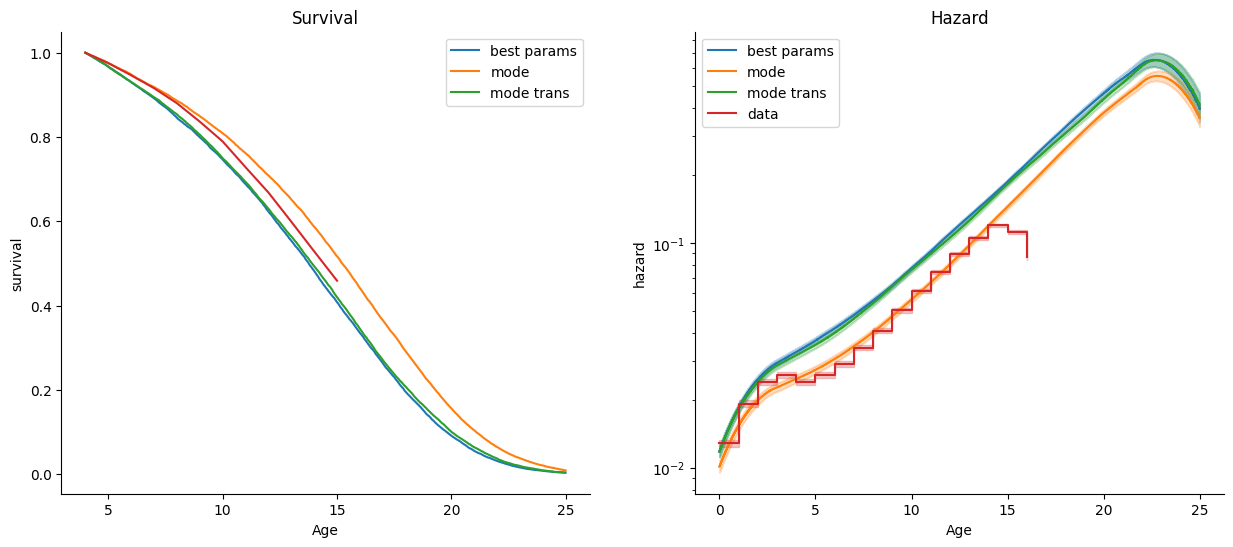

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0], label='best params',time_range=time_range, title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0, label='mode',time_range=time_range,)
sim_mode_trans.plotSurvival(ax=ax0, label='mode trans',time_range=time_range,)
ds.plotSurvival(ax=ax0, label='data',time_range=time_range,)

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

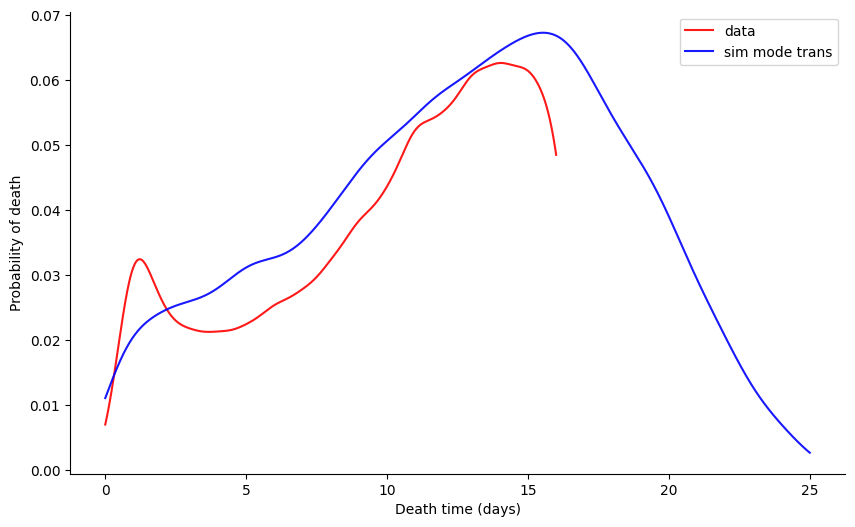

In [81]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=True, label='data', color='r',alpha=0.9)
sim_mode_trans.plotDeathTimesDistribution(ax=ax,use_kde=True, label='sim mode trans', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 4053/4053 [00:00<00:00, 391928.67it/s]


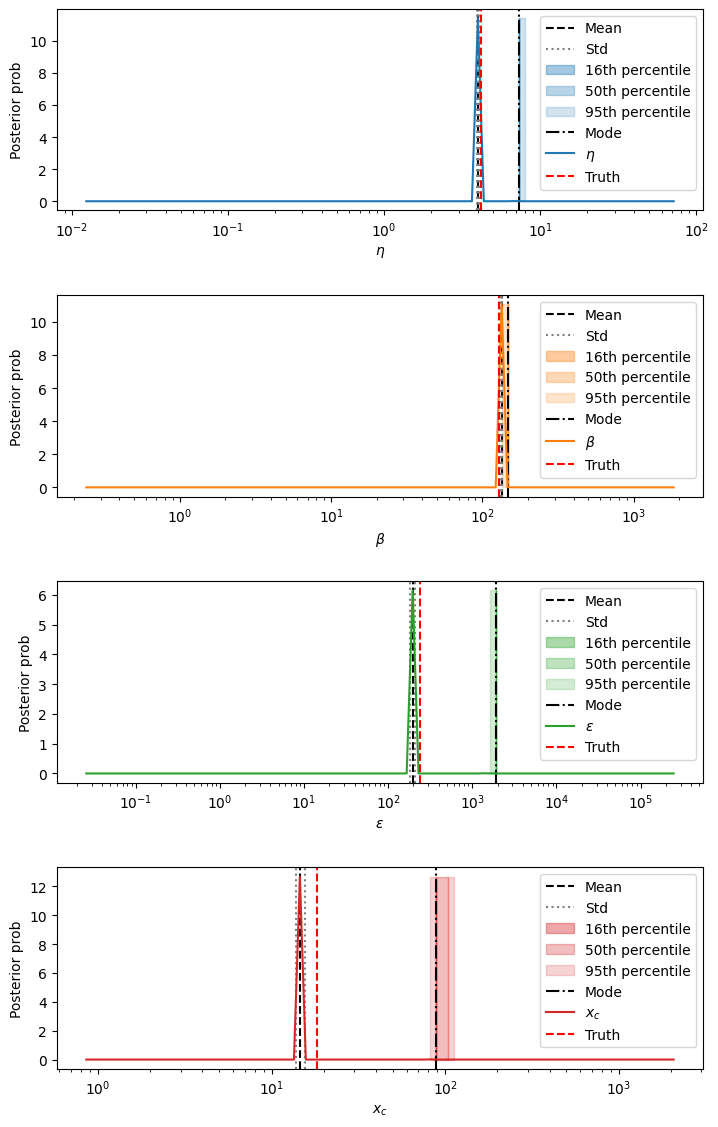

In [82]:
import samples_utils as su
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$","ExtH"], truths=sorted_samples[-1],scale='log')